**rajvi using steph's code**

In [36]:
from rajvi_mapbox_api import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium

In [37]:
branchRadii = gpd.read_file('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [38]:
api = MapboxAPI()

In [39]:
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

#permanentlyClosed = branchRadii[((branchRadii['PERMANENTLY_CLOSED'] == '1'))].index
#branchRadii = branchRadii.drop(permanentlyClosed)

branchRadii = branchRadii.drop(['HOURS OF OPERATION', 'ADDRESS', 
                                'CITY', 'STATE', 'ZIP', 'PHONE', 'WEBSITE'], axis=1)

branchRadii = branchRadii[(branchRadii['BRANCH'] != 'Roosevelt')]
branchRadii.reset_index(inplace = True)
branchRadii2 = branchRadii.copy(deep = True)

#api_response = api.get_data((branchRadii.loc[0,'LATITUDE'],branchRadii.loc[0,'LONGITUDE']), 5)
#branchRadii.loc[0,'geometry'] = shape(api_response)

#branchRadii
#branchRadii2

In [40]:
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branchRadii[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')

/tmp/ipykernel_1951284/198900148.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_1951284/198900148.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]


In [41]:
for i in range(branchRadii.shape[0]):
    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 15)
    branchRadii.loc[i,'geometry'] = shape(api_response)

for i in range(branchRadii2.shape[0]):
    api_response =  api.get_data((branchRadii2.loc[i,'LATITUDE'],branchRadii2.loc[i,'LONGITUDE']), 25)
    branchRadii2.loc[i,'geometry'] = shape(api_response)

In [42]:


branchRadii = branchRadii.set_crs('epsg:4326')
branchRadii2 = branchRadii2.set_crs('epsg:4326')

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")

In [43]:
# makes map with ALL THE OVERLAPS

#fig, ax = plt.subplots(1, figsize=(8, 8))
#base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
#ax.axis('off')

#branchRadii2.plot(ax=base, alpha = .5, color = 'lightgreen')
#branchRadii.plot(ax=base, alpha = .5, color='green')
                                    
#branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

In [7]:
#branchRadii
#branchRadii2

In [8]:
# makes map with no overlaps bw smallest radius and larger radius within one library 

#outerRadiusMinusSmaller = branchRadii[['BRANCH', 'geometry']]
#outerRadiusMinusSmaller['geometry'] = branchRadii2.difference(branchRadii)
#outerRadiusMinusSmaller

#fig, ax = plt.subplots(1, figsize=(8, 8))
#base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
#ax.axis('off')

#outerRadiusMinusSmaller.plot(ax=base, alpha = .5, color = 'red')
#branchRadii.plot(ax=base, alpha = .5, color='green')
                                    
#branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

In [10]:
# combines all larger radii -- not really useful
allLargeRadiiCombined = gpd.GeoDataFrame({'BRANCH': [branchRadii2.loc[0,'BRANCH']],'geometry': [branchRadii2.loc[0,'geometry']]})
allLargeRadiiCombined

for i in range(branchRadii2.shape[0]):    
    comparisonBranch = {'BRANCH': [branchRadii2.loc[i,'BRANCH']],'geometry': [branchRadii2.loc[i,'geometry']]}
    comparisonRadius = gpd.GeoDataFrame(comparisonBranch)
    combinedArea = (allLargeRadiiCombined['geometry']).union(comparisonRadius['geometry'])
    allLargeRadiiCombined['geometry'] = combinedArea
    
#allLargeRadiiCombined

In [10]:
# Plots large geometry of outer radius for all libraries

#fig, ax = plt.subplots(1, figsize=(8, 8))
#base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
#ax.axis('off')

#allLargeRadiiCombined.plot(ax=base, alpha = .5, color = 'green')
                                    
#branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);
#branchRadii2

In [11]:
branchRadii2Mod = branchRadii2.copy(deep = True)

In [12]:
outerRadiusNoOverlap = gpd.GeoDataFrame(columns=['BRANCH','geometry'], geometry='geometry', crs='EPSG:4326')

for i in range(branchRadii2Mod.shape[0]):    
    oneLargeRadius = gpd.GeoDataFrame({'BRANCH': [branchRadii2Mod.loc[i,'BRANCH']],'geometry': [branchRadii2Mod.loc[i,'geometry']]})
    #oneBranchData = {'BRANCH': [branchRadii2Mod.loc[i,'BRANCH']],'geometry': [branchRadii2Mod.loc[i,'geometry']]}
    #oneLargeRadius = gpd.GeoDataFrame(oneBranchData, crs="EPSG:4326")
    for j in range(branchRadii2Mod.shape[0]):
        if (i != j):
            rotatingSmallRadius = gpd.GeoDataFrame({'BRANCH': [branchRadii2Mod.loc[j,'BRANCH']],'geometry': [branchRadii2Mod.loc[j,'geometry']]})
            outerOnly = oneLargeRadius.difference(rotatingSmallRadius)
            oneLargeRadius['geometry'] = outerOnly[0]
    outerRadiusNoOverlap = pd.concat([outerRadiusNoOverlap, oneLargeRadius])
    branchRadii2Mod.loc[i, 'geometry'] = outerOnly[0]

/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting o

In [64]:
print(oneLargeRadius.type)
oneLargeRadius = oneLargeRadius.set_crs('epsg:4326')
oneLargeRadius.crs

0    Polygon
dtype: object


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
outerRadiusNoOverlap.reset_index(inplace = True)
outerRadiusNoOverlap

,index,BRANCH,geometry
0,0,Albany Park,"POLYGON ((-87.71193 41.96824, -87.71297 41.969..."
1,0,Altgeld,"POLYGON ((-87.61353 41.65389, -87.61284 41.654..."
2,0,Archer Heights,"MULTIPOLYGON (((-87.70892 41.80451, -87.70846 ..."
3,0,Austin,"POLYGON ((-87.77716 41.89627, -87.77098 41.892..."
4,0,Austin-Irving,"POLYGON ((-87.79129 41.96290, -87.78916 41.963..."
...,...,...,...
76,0,West Pullman,"POLYGON ((-87.64617 41.69384, -87.64317 41.696..."
77,0,West Town,"POLYGON ((-87.66396 41.90962, -87.66350 41.909..."
78,0,"Whitney M. Young, Jr.","POLYGON ((-87.62486 41.74310, -87.62595 41.739..."
79,0,Woodson Regional Library,"POLYGON ((-87.61818 41.72169, -87.62048 41.719..."


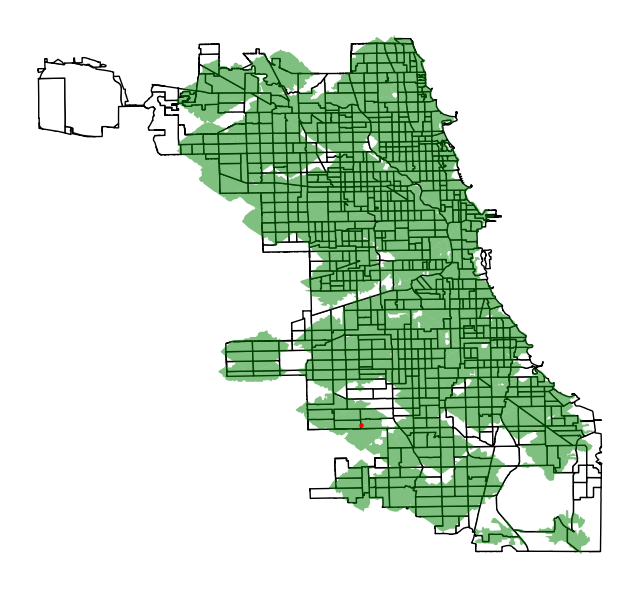

In [35]:
fig, ax = plt.subplots(1, figsize=(8, 8))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii2Mod.plot(ax=base, alpha = .5, color = 'green')
          
#oneBranch = [branchLocsOnly.iloc[0]]
oneBranch = gpd.GeoDataFrame({'BRANCH': [branchLocsOnly.loc[80,'BRANCH']],'geometry': [branchLocsOnly.loc[80,'geometry']]})
oneBranch.plot(ax=base, marker='o', color='red', markersize=5);
#oneBranch

In [1]:
noOverlap = branchRadii[['BRANCH', 'geometry']]
noOverlap['geometry'] = outerRadiusNoOverlap.difference(branchRadii)
#outerRadiusMinusSmaller

fig, ax = plt.subplots(1, figsize=(8, 8))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

noOverlap.plot(ax=base, alpha = .5, color = 'green')
branchRadii.plot(ax=base, alpha = .5, color='yellow')
                                    
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

NameError: name 'branchRadii' is not defined